In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
pwd

'/content'

In [4]:
%cd /content/drive/MyDrive/Colab Notebooks/BT_TeamProject/Pneumonia Detection

/content/drive/MyDrive/Colab Notebooks/BT_TeamProject/Pneumonia Detection


# 0. 라이브러리 호출

In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import math
import cv2

from tensorflow.keras.preprocessing.image import load_img
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

import pickle

# 1. 데이터 호출 및 전처리

In [6]:
# 이미지 크기 설정
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256
BATCH_SIZE = 32

In [7]:
# 데이터 디렉토리 경로 설정
train_dir = './chest_xray/train'
test_dir = './chest_xray/test'

In [8]:
# 클래스 라벨 설정
class_labels = {'NORMAL': 0, 'PNEUMONIA': 1}
label_names = {v: k for k, v in class_labels.items()}

In [9]:
# 데이터셋 생성 함수
def create_dataset(directory):
    images = []
    labels = []
    for class_name in os.listdir(directory):
        class_dir = os.path.join(directory, class_name)
        if not os.path.isdir(class_dir):
            continue
        for file_name in os.listdir(class_dir):
            file_path = os.path.join(class_dir, file_name)
            if file_name.endswith('.jpeg'): # 이 부분에서 데이터 타입을 추가할 수 있음
                #cv2 라이브러리로 이미지 로드 및 전처리 (grayscale)
                image = cv2.imread( file_path, cv2.IMREAD_GRAYSCALE )
                #이미지 리사이징
                resizedImg = cv2.resize( image, (IMAGE_HEIGHT, IMAGE_WIDTH) )
                #이미지 정규화
                resizedImg = np.expand_dims(resizedImg, axis = -1)
                image = resizedImg.astype('float32')
                image /= 255.0
                #images에 모으기
                images.append( image )

                # 라벨 설정
                if class_name == 'NORMAL':
                    labels.append(class_labels['NORMAL'])
                else :
                  labels.append(class_labels['PNEUMONIA'])

    return np.array(images), np.array(labels)

### ---파일 개수 확인

In [ ]:
# import os

# def count_images(directory):
#     normal_count = 0
#     pneumonia_count = 0
#     for class_name in os.listdir(directory):
#         class_dir = os.path.join(directory, class_name)
#         if not os.path.isdir(class_dir):
#             continue
#         for file_name in os.listdir(class_dir):
#             if file_name.endswith('.jpeg'):
#                 if class_name == 'NORMAL':
#                     normal_count += 1
#                 elif class_name == 'PNEUMONIA':
#                     pneumonia_count += 1
#     return normal_count, pneumonia_count

# # dir에서 NORMAL과 PNEUMONIA 파일의 개수 세기
# dir_name =  (train_dir or test_dir)
# normal_count, pneumonia_count = count_images( dir_name )

# print("Train 데이터셋:", dir_name)
# print("NORMAL 파일 개수:", normal_count)
# print("PNEUMONIA 파일 개수:", pneumonia_count)


Train 데이터셋:
NORMAL 파일 개수: 234
PNEUMONIA 파일 개수: 390




---



In [10]:
# 데이터 로드
train_images, train_labels = create_dataset(train_dir)
test_images, test_labels = create_dataset(test_dir)

## -- 이미지 출력하기

In [10]:
train_images[0]

array([[[0.09019608],
        [0.07058824],
        [0.07058824],
        ...,
        [0.3647059 ],
        [0.3764706 ],
        [0.37254903]],

       [[0.08627451],
        [0.08235294],
        [0.07450981],
        ...,
        [0.36078432],
        [0.36862746],
        [0.37254903]],

       [[0.09019608],
        [0.08627451],
        [0.07843138],
        ...,
        [0.3647059 ],
        [0.36862746],
        [0.37254903]],

       ...,

       [[0.11372549],
        [0.11372549],
        [0.11372549],
        ...,
        [0.2509804 ],
        [0.25882354],
        [0.25490198]],

       [[0.14117648],
        [0.13725491],
        [0.14117648],
        ...,
        [0.32156864],
        [0.34117648],
        [0.34117648]],

       [[0.18431373],
        [0.1882353 ],
        [0.18039216],
        ...,
        [0.44313726],
        [0.45490196],
        [0.44313726]]], dtype=float32)

In [11]:
test_images[0]

array([[[0.15686275],
        [0.14509805],
        [0.14509805],
        ...,
        [0.12156863],
        [0.11372549],
        [0.11764706]],

       [[0.15294118],
        [0.14117648],
        [0.14117648],
        ...,
        [0.11372549],
        [0.12156863],
        [0.12156863]],

       [[0.16078432],
        [0.14509805],
        [0.14509805],
        ...,
        [0.11372549],
        [0.10980392],
        [0.12156863]],

       ...,

       [[0.12156863],
        [0.10980392],
        [0.10588235],
        ...,
        [0.13725491],
        [0.12941177],
        [0.12941177]],

       [[0.10588235],
        [0.11372549],
        [0.12156863],
        ...,
        [0.14117648],
        [0.13333334],
        [0.13333334]],

       [[0.11764706],
        [0.10588235],
        [0.11764706],
        ...,
        [0.14509805],
        [0.12941177],
        [0.13333334]]], dtype=float32)

In [12]:
# 플로팅 함수
def plot_images(images, labels, label_names, num_images):
    # 랜덤하게 num_images 개수만큼 선택
    indices = np.random.choice(len(images), num_images, replace=False)
    selected_images = images[indices]
    selected_labels = labels[indices]

    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(4, 4, i + 1)
        plt.imshow(selected_images[i].squeeze(), cmap='gray')
        plt.title(label_names[selected_labels[i]])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

Text(0.5, 1.0, 'PNEUMONIA')

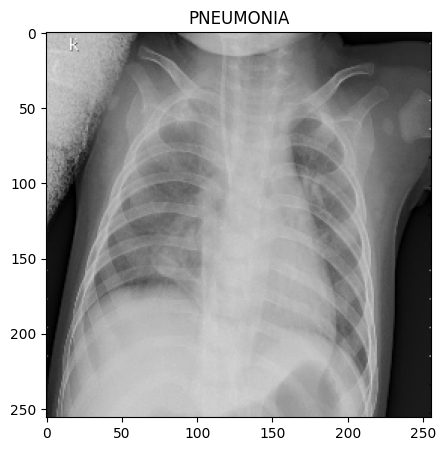

In [13]:
IMG_NUM = 600
plt.figure(figsize = (5,5))
plt.imshow(test_images[IMG_NUM], cmap='gray')
plt.title(label_names[test_labels[IMG_NUM]])

Text(0.5, 1.0, 'PNEUMONIA')

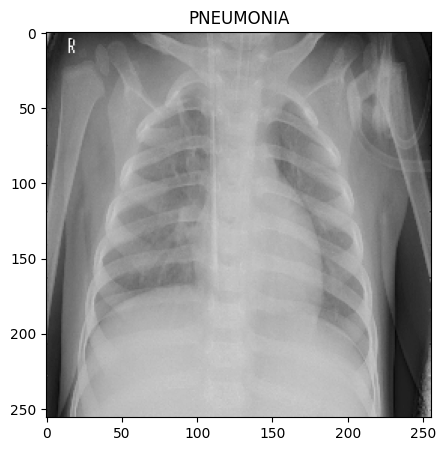

In [15]:
IMG_NUM = 600
plt.figure(figsize = (5,5))
plt.imshow(train_images[IMG_NUM], cmap='gray')
plt.title(label_names[train_labels[IMG_NUM]])

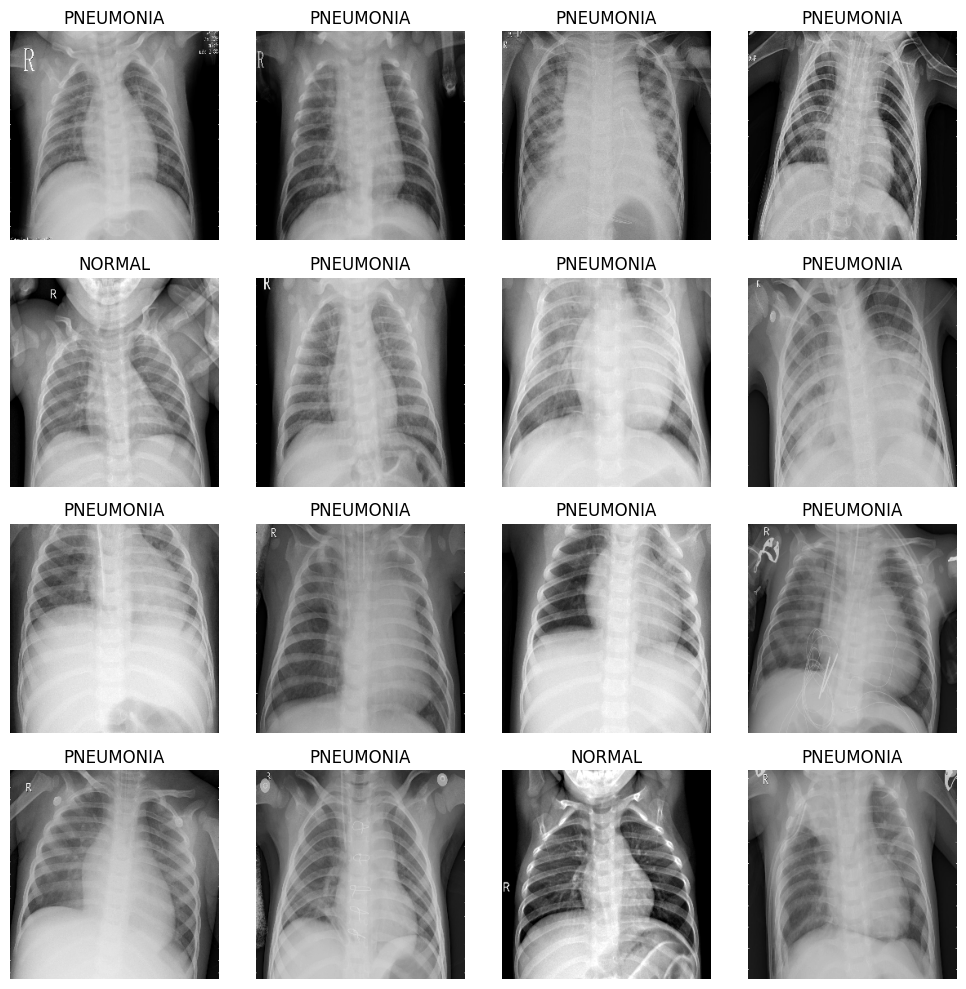

In [16]:
plot_images(train_images, train_labels, label_names, 16)

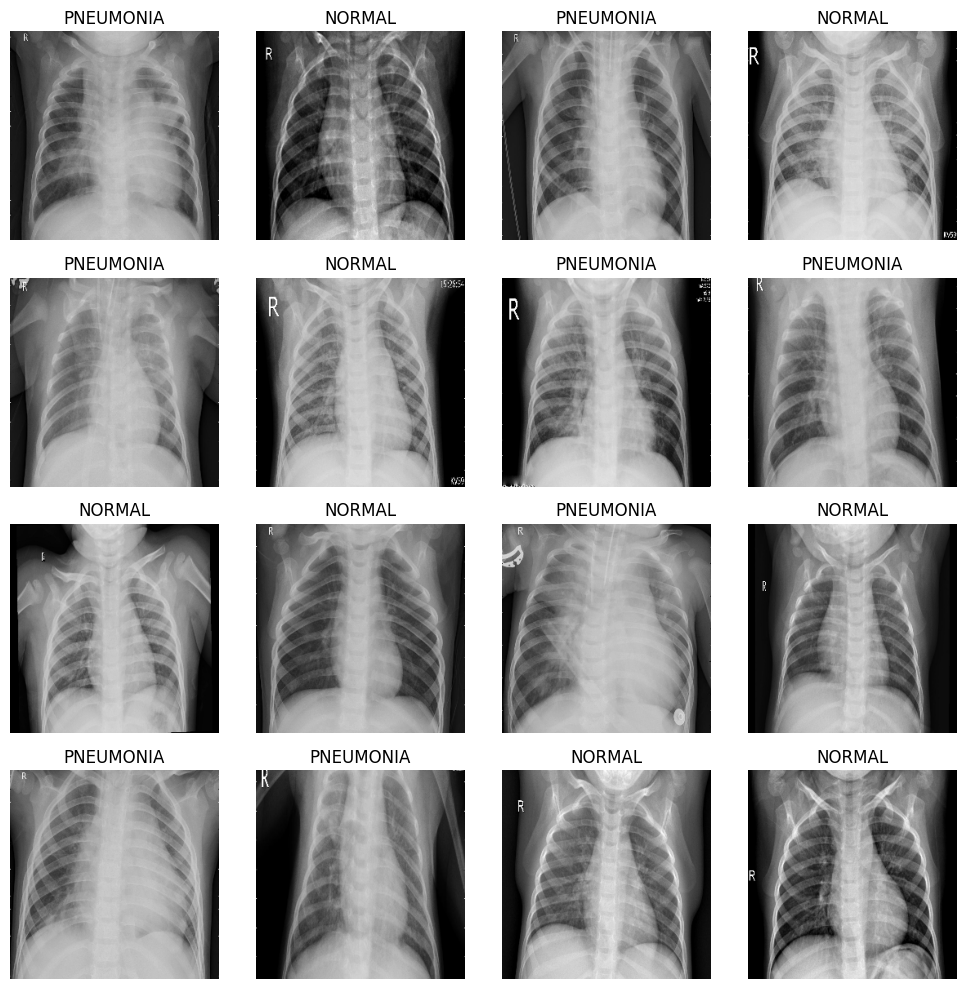

In [17]:
plot_images(test_images, test_labels, label_names, 16)

# 2. 모델 생성 및 훈련

### Train Validation Split

In [ ]:
train_images[0].shape

(256, 256, 1)

In [18]:
input_shape = train_images[0].shape

In [ ]:
input_shape

(256, 256, 1)

In [ ]:
# 모델 생성
model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape = input_shape),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Dropout(rate=0.8),
    Conv2D(32, (3, 3), activation='relu'),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Dropout(rate=0.8),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')  # 클래스 수에 맞게 조정
])

In [ ]:
# 모델 컴파일
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
# 모델 요약 정보 출력
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      160       
                                                                 
 conv2d_1 (Conv2D)           (None, 252, 252, 32)      4640      
                                                                 
 max_pooling2d (MaxPooling2  (None, 126, 126, 32)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 126, 126, 32)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 124, 124, 32)      9248      
                                                                 
 conv2d_3 (Conv2D)           (None, 122, 122, 32)      9248      
                                                        

In [ ]:
# 모델 훈련
history = model.fit(train_images,
                    train_labels,
                    epochs=10,
                    validation_split = 0.2)

Epoch 1/10
111/111 [==============================] - 28s 166ms/step - loss: 0.5052 - accuracy: 0.8425 - val_loss: 0.2263 - val_accuracy: 1.0000
Epoch 2/10
111/111 [==============================] - 14s 127ms/step - loss: 0.2675 - accuracy: 0.8484 - val_loss: 0.0686 - val_accuracy: 0.9977
Epoch 3/10
111/111 [==============================] - 14s 128ms/step - loss: 0.1969 - accuracy: 0.9280 - val_loss: 0.0959 - val_accuracy: 0.9831
Epoch 4/10
111/111 [==============================] - 15s 131ms/step - loss: 0.1794 - accuracy: 0.9390 - val_loss: 0.0368 - val_accuracy: 0.9944
Epoch 5/10
111/111 [==============================] - 15s 131ms/step - loss: 0.1609 - accuracy: 0.9483 - val_loss: 0.0748 - val_accuracy: 0.9695
Epoch 6/10
111/111 [==============================] - 15s 133ms/step - loss: 0.1595 - accuracy: 0.9531 - val_loss: 0.0248 - val_accuracy: 0.9944
Epoch 7/10
111/111 [==============================] - 14s 130ms/step - loss: 0.1441 - accuracy: 0.9579 - val_loss: 0.0276 - val_ac

In [ ]:
# 모델 평가
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print("테스트 데이터 정확도:", test_accuracy)

20/20 [==============================] - 0s 20ms/step - loss: 0.7879 - accuracy: 0.7821
테스트 데이터 정확도: 0.7820512652397156


## -- 저장된 모델 호출하기

In [11]:
loadedModel = load_model("./model_02.h5")

In [20]:
loadedModel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      160       
                                                                 
 conv2d_1 (Conv2D)           (None, 252, 252, 32)      4640      
                                                                 
 max_pooling2d (MaxPooling2  (None, 126, 126, 32)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 126, 126, 32)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 124, 124, 32)      9248      
                                                                 
 conv2d_3 (Conv2D)           (None, 122, 122, 32)      9248      
                                                        

In [21]:
test_loss, test_accuracy = loadedModel.evaluate(test_images, test_labels)
print("테스트 데이터 정확도:", test_accuracy)

20/20 [==============================] - 4s 44ms/step - loss: 0.7128 - accuracy: 0.7965
테스트 데이터 정확도: 0.7964743375778198


# 예측 테스트

In [ ]:
# 이미지 전처리
def ImgPreprocess(file, height, width): # file path가 아닐 수도 있음
  images = []
  image = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
  resizedImg = cv2.resize(image, (height, width))
  resizedImg = np.expand_dims(resizedImg, axis = -1)
  image = resizedImg.astype("float32")
  image /=255.0
  images.append(image)

  return np.array(images)

In [ ]:
test_file = "./chest_xray/train/PNEUMONIA/person1000_bacteria_2931.jpeg"

In [ ]:
ex_img = ImgPreprocess(test_file, IMAGE_HEIGHT, IMAGE_WIDTH)

In [ ]:
ex_img.shape

(1, 256, 256, 1)

In [ ]:
predictions = list(model.predict(ex_img))[0][0]
predictions

1/1 [==============================] - 0s 30ms/step


0.99999106

In [ ]:
binary_predictions = (predictions > 0.8).astype(int)
binary_predictions

1

In [ ]:
label_names[binary_predictions]

'PNEUMONIA'

In [ ]:
round_percent = np.round(predictions * 100, 4)
print(round_percent,"%")

99.9991 %




---



# ModelDict 저장

In [ ]:
# 클래스 라벨 설정
class_labels = {'NORMAL': 0, 'PNEUMONIA': 1}
label_names = {v: k for k, v in class_labels.items()}

In [ ]:
pwd

'/content/drive/MyDrive/Colab Notebooks/BT_TeamProject/Pneumonia Detection'

In [ ]:
file_path = "/content/drive/MyDrive/Colab Notebooks/BT_TeamProject/Pneumonia Detection/model_dict_03.pkl" # 이름 변경할 때는 이거 수정해야 함
file_path

'/content/drive/MyDrive/Colab Notebooks/BT_TeamProject/Pneumonia Detection/model_dict_03.pkl'

In [ ]:
height = loaded_dict['IMAGE_HEIGHT']
width = loaded_dict['IMAGE_WIDTH']

In [ ]:
ModelDict = {}

In [ ]:
ModelDict["IMAGE_HEIGHT"] = IMAGE_HEIGHT
ModelDict["IMAGE_WIDTH"] = IMAGE_WIDTH
ModelDict["LABEL_NAMES"] = label_names

In [ ]:
ModelDict

{'IMAGE_HEIGHT': 256,
 'IMAGE_WIDTH': 256,
 'LABEL_NAMES': {0: 'NORMAL', 1: 'PNEUMONIA'}}

In [ ]:
with open(file_path, "wb") as f:
  pickle.dump(ModelDict, f)



---



# Accuracy Plot

In [ ]:
# loadedModel = load_model("./model_02.h5")
# test_loss, test_accuracy = loadedModel.evaluate(test_images, test_labels)
# print("테스트 데이터 정확도:", test_accuracy)

In [12]:
# 모델 평가
y_pred = loadedModel.predict(test_images)
y_pred

20/20 [==============================] - 33s 2s/step


array([[0.4852362 ],
       [0.39193708],
       [0.43714252],
       [0.39193708],
       [0.39193708],
       [0.96701837],
       [0.9992886 ],
       [0.39193708],
       [0.45351124],
       [0.39193708],
       [0.39193708],
       [0.39193708],
       [0.39193708],
       [0.39193708],
       [0.42206445],
       [0.486495  ],
       [0.39193708],
       [0.39193708],
       [0.39193708],
       [0.92429256],
       [0.9787756 ],
       [0.41752553],
       [0.72869897],
       [0.39193708],
       [0.4002444 ],
       [0.39193708],
       [0.39193708],
       [0.39193708],
       [0.39193708],
       [0.39193708],
       [0.617482  ],
       [0.39193708],
       [0.9450655 ],
       [0.39193708],
       [0.916167  ],
       [0.48264974],
       [0.39193708],
       [0.39193708],
       [0.58809286],
       [0.39193708],
       [0.39193708],
       [0.94505066],
       [0.8713289 ],
       [0.64302546],
       [0.90113926],
       [0.5436842 ],
       [0.45647907],
       [0.391

In [45]:
# 임계값 테스트
thresholds = np.arange(0.0, 1.0, 0.01)
best_accuracy = 0
best_threshold = 0

for threshold in thresholds:
    y_pred_classes = (y_pred > threshold).astype(int).flatten()
    accuracy = accuracy_score(test_labels, y_pred_classes)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_threshold = threshold

In [47]:
best_threshold, best_accuracy

(0.93, 0.8669871794871795)

In [48]:
# 이진 클래스 변환
y_pred_classes = (y_pred > 0.93).astype(int).flatten()

In [49]:
y_pred_classes.shape

(624,)

In [43]:
y_true = test_labels

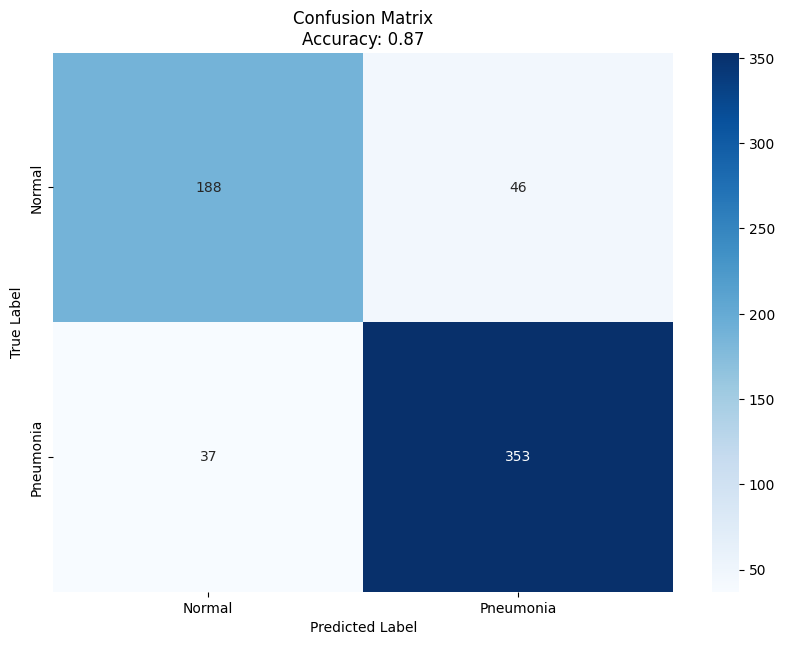

In [50]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
# 혼동 행렬 계산
cm = confusion_matrix(y_true, y_pred_classes)
accuracy = accuracy_score(y_true, y_pred_classes)

# 시각화
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Confusion Matrix\nAccuracy: {accuracy:.2f}')
plt.show()

# 훈련 모델 저장

In [ ]:
model.save('model_04.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
